<a href="https://colab.research.google.com/github/JossRubio/Desafios_Data_Scientist/blob/main/Notebooks/Desafio_Data_Scientist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Desafío Data Scientist Caja Los Andes

**Nombre: José Manuel Rubio Cienfuegos**

**RUT: 21.272.943-4**

##Librerías

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import make_column_transformer

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

##Carga de Datos

In [44]:
df = pd.read_csv('dataset_Caso_1.csv')

##Análisis exploratorio de datos

Antes de realizar cualquier tipo de procesamiento es necesario conocer los datos que conforman el dataframe, que tipos de datos, las clases y si existe un desbalance de estas

In [45]:
df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,target
0,50.1341,-326.0000,SAT,MZBER,0,0,6,-6.5,0
1,50.1341,-326.0000,SAT,MZBER,0,0,6,-4.5,0
2,124.3276,-275.1935,LCV,MZBER,0,0,3,-2.5,0
3,50.1341,-326.0000,SAT,MZBER,0,0,3,-4.5,0
4,85.3905,-298.8632,XJB,MZBER,0,0,5,-4.5,0


Se aprecia que la base de datos contiene floats y variables categoricas 

In [46]:
print('Dimensiones del dataframe original', df.shape)
df.dropna(inplace=True)
print('Dimensiones despues de remover muestras con nans', df.shape)

Dimensiones del dataframe original (2000, 9)
Dimensiones despues de remover muestras con nans (2000, 9)


Cuenta con 2000 muestras y 9 columnas, siendo la última la etiqueta de la muestra. Además de que no se cuenta con muestras nans.

In [47]:
df.target.value_counts()

0    1978
1      22
Name: target, dtype: int64

Las clases estan muy desbalanceadas

In [48]:
df.x3.value_counts()

LCV    926
SAT    715
XJB    280
QKP     79
Name: x3, dtype: int64

Al igual que otras características del dataset

In [49]:
df.x4.value_counts()

MZBER    1918
YEQA       41
PQKE       36
ZUQF        5
Name: x4, dtype: int64

##Preprocesamiento de datos

Dado que la base de datos tiene diversos tipos de datos, valores elevados en algunas columnas y hay un desbalance de clases, se debe realizar un preprocesamiento de esta información antes de llevarla al modelo.

###One Hot Encoding

Dado que se tienen columnas con variables categoricas, en primer lugar esta información se debe transformar para que pueda ser procesada dentro de los modelos. Para ello se utiliza One Hot Encoding el cual convierte las variables categóricas a un arreglo binario

In [50]:
# Inicializando el objeto conversor con la codificación One Hot para la conversión de las variables categoricas.
transformer = make_column_transformer((OneHotEncoder(), ['x3','x4']), remainder='passthrough')

# Entrenado el objeto con los datos del dataframe
transf = transformer.fit_transform(df)

# Aplicando la codificación para realizar la conversión de las variables categoricas al dataframe original
df_transf = pd.DataFrame(transf, columns=transformer.get_feature_names_out())

Con esto el dataframe incorpora la variable categórica en forma de un arreglo binario, aunque esto provoque el aumento de la cantidad de columnas del dataframe.

In [51]:
df_transf.head()

,onehotencoder__x3_LCV,onehotencoder__x3_QKP,onehotencoder__x3_SAT,onehotencoder__x3_XJB,onehotencoder__x4_MZBER,onehotencoder__x4_PQKE,onehotencoder__x4_YEQA,onehotencoder__x4_ZUQF,remainder__x1,remainder__x2,remainder__x5,remainder__x6,remainder__x7,remainder__x8,remainder__target
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,50.1341,-326.0000,0.0,0.0,6.0,-6.5,0.0
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,50.1341,-326.0000,0.0,0.0,6.0,-4.5,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,124.3276,-275.1935,0.0,0.0,3.0,-2.5,0.0
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,50.1341,-326.0000,0.0,0.0,3.0,-4.5,0.0
4,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,85.3905,-298.8632,0.0,0.0,5.0,-4.5,0.0


###Normalización de datos

Otro punto importante es la normalización de los datos, debido a que se tiene valores altos en algunas columnas, con esto el sistema aligera su entrenamiento. Para ello se utilizará el objeto StandarScaler de *sklearn*

In [52]:
df_X = df_transf.drop(['remainder__target'], axis=1)          # Eliminando la columna con las clases para realizar la normalización

scaler = StandardScaler()                                     # Llamando el objeto StandarScaler

scaler.fit(df_X)                                              # Entrenando el objeto con los features del dataframe

X_scaled = scaler.transform(df_X)                             # Normalizando los valores del conjunto de características

### Filtración de características

Dado que se aplicó un One Hot Encoding para añadir las variables categóricas, la cantidad de características aumentó. 

In [53]:
df_X.columns

Index(['onehotencoder__x3_LCV', 'onehotencoder__x3_QKP',
       'onehotencoder__x3_SAT', 'onehotencoder__x3_XJB',
       'onehotencoder__x4_MZBER', 'onehotencoder__x4_PQKE',
       'onehotencoder__x4_YEQA', 'onehotencoder__x4_ZUQF', 'remainder__x1',
       'remainder__x2', 'remainder__x5', 'remainder__x6', 'remainder__x7',
       'remainder__x8'],
      dtype='object')

Entonces, para reducir la dimenisonalidad se realizad un filtrado de estas características donde solo se tomarán las más importantes. Esto se hará a traves de una matriz de correlación, para obtener las características más correlacionadas con respecto a la clase.

In [54]:
columns_names = df_X.columns.tolist()                         # Nombre de columnas para el Dataframe con los datos normalizados
df_process = pd.DataFrame(X_scaled, columns=columns_names)    # Dataframe con los valores de X normalizados

df_process['target'] = df_transf.remainder__target            # Incorporando las clases al dataframe

target_correlation = abs(df_process.corr().target.iloc[:-1])  # Correlación positiva de las variables con respecto al target
order_features_correlation = target_correlation.sort_values(ascending=False).index  # Características ordenadas por correlación de forma descendente

Con esto se obtiene un listado de importancia de características según la clase

In [66]:
order_features_correlation.tolist()

['remainder__x5',
 'remainder__x6',
 'onehotencoder__x3_QKP',
 'onehotencoder__x4_YEQA',
 'onehotencoder__x4_MZBER',
 'onehotencoder__x3_SAT',
 'remainder__x1',
 'remainder__x8',
 'onehotencoder__x4_PQKE',
 'remainder__x2',
 'onehotencoder__x3_XJB',
 'remainder__x7',
 'onehotencoder__x4_ZUQF',
 'onehotencoder__x3_LCV']

Entonces con esta información se realizar el filtrado de características, con lo que se construyen los datasets de características y de clases que se llevará al modelo.

In [55]:
# Filtración de colummas para la reducción de la dimensionalidad.

features = 10                                                     # Cantidad de características, máximo 14

df_X = df_process[order_features_correlation[:features].tolist()] # Filtrando las columnas para obtener las características a utilizar.
df_y = df_process.target                                          # Dataframe con las clases de las muestras.

###Construcción de conjuntos de entrenamiento y prueba.

Teniendo los dataframes con las características y clases, entonces estos se separan en conjuntos de entrenamiento y prueba. Para ello se utiliza la función *train_test_split* de *sklearn*, ya que esta permite la construcción rápida de estos conjuntos. Además esta función incluye parámetros que permiten controlar la proporción de clases en ambos conjuntos y el tamaño de estos. Se utiliza un 70% de datos para el entrenamiento y un 30% para las pruebas.

In [56]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=.3, stratify=df_y, random_state=3)

##Modelo de clasificación

Con los conjuntos de entrenamiento y prueba, se implementa un modelo de machine learning para realizar las clasificaciones. Dado que se esta trabajando con un problema de clasificación binaria y no se cuentan con muchos datos, se utiliza un *Support Vector Machine*. Este modelo de aprendizaje supervisado puede realizar las clasificaciones mediante la construcción de un hiperplano que separa las muestras en diferentes clases. 

Este sistema se configuró inicialmente para realizar este trabajo con 2 categorías, por lo que tiene buenos rendimientos al trabajar con problemas de clasificación binaria.

Para el uso del *Support Vector Machine* se utiliza el objeto SVC de *sklearn*, y dado que este viene configurado para realizar clasificaciones de varias clases, se ajustan unos hiperparámetros de este objeto para poder controlar el modelo.

Se utiliza un kernel lineal ya que estamos trabajando con 2 clases solamente, y se ajusta el peso de las clases como 'balanced', esto es debido al gran desbalance de clases que poseen los datos. 

In [57]:
svm_parameters = {}                                 
svm = SVC(kernel='linear', class_weight='balanced')

model = GridSearchCV(svm, svm_parameters, verbose=1, cv=5)

Finalmente se incorpora un pequeño GridSearch, esto con la finalidad de aplicar una validación cruzada al entrenamiento

###Entrenamiento

Este se realiza con las características y clases del conjunto de entrenamiento definido anteriormente.

In [58]:
model.fit(X_train, y_train)         # Entrenamiento del modelo

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5, estimator=SVC(class_weight='balanced', kernel='linear'),
             param_grid={}, verbose=1)

##Resultados

Con el sistema entrenado, entonces se realizan predicciones las cuales son evaluadas mediante diferentes métricas.

In [59]:
y_pred = model.predict(X_test)        # Predicciones del conjunto de prueba.

class_names = ['0', '1']              # Nombres de las clases.
print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0)) # Cálculo de métricas sobre el conjunto de prueba.

              precision    recall  f1-score   support

           0       1.00      0.97      0.99       593
           1       0.27      0.86      0.41         7

    accuracy                           0.97       600
   macro avg       0.64      0.92      0.70       600
weighted avg       0.99      0.97      0.98       600



Si bien se obtuvo un *accuracy* alto, al tener clases muy desbalanceadas, esta métrica no es precisa. Dado esto, para una mejor evaluación de este sistema se utiliza el AUC, siendo este el valor del área bajo la curva ROC. Esta métrica es más fiable ya que se necesita saber que tan probable es que el sistema pueda encontrar las muestras 1 por sobre las muestras 0. 

### AUC conjunto de entrenamiento

In [ ]:
print(round(roc_auc_score(y_train, model.decision_function(X_train)), 5))

0.82489


### AUC conjunto de prueba

In [ ]:
print(round(roc_auc_score(y_test, model.decision_function(X_test)), 5))

0.85208


###Visualización de la clasificación

Finalmente se realiza una visualización de la clasificación de las muestras, para ello se implementa la función *plot_confusion_matrix*, donde esta muestra la matriz de confusión obtenida tras la clasificación de las muestras del conjunto de prueba.

Cabe destacar que a diferencia de la matriz de confusión normal, que representa la cantidad exacta muestras clasificadas, esta realiza una normalización de esta información. Esto es debido al gran desbalance de clases, ya que aunque si el sistema fuese perfecto, solo se destacarían las muestras 0 en la representación.

In [60]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues, fig_size=(7,7)):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)
    plt.figure(figsize=fig_size)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Aplicando esta función, entonces se obtiene la matriz de confusión normalizada para cada clase.

Normalized confusion matrix


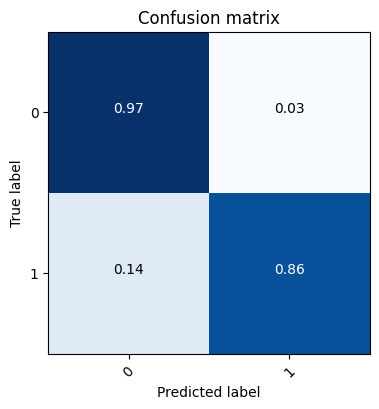

In [61]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, class_names, fig_size=(4,4))